<div style='background-image: url("../../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Computational Seismology</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Reproducible Papers - Syngine Paper</div>
        </div>
    </div>
</div>

---

# Figure 2: Source Width Parameter

This notebook is part of the supplementary materials for the Syngine paper and reproduces figure 2.

Requires matplotlib >= 1.5 and an ObsPy version with the syngine client (>= 1.0) as well as instaseis.

##### Authors:
* Lion Krischer ([@krischer](https://github.com/krischer))

In [1]:
%matplotlib inline

import obspy
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("seaborn-whitegrid")

import copy
import io
import instaseis
import json

import requests

In [2]:
SYNGINE_URL = "http://service.iris.edu/irisws/syngine/1/query"

In [3]:
network = "IU"
station = "ANMO"

# Get station information from the IRIS FDSN service.
from obspy.clients.fdsn import Client
c = Client("IRIS")
print(c.get_stations(network=network, station=station, format="text")[0][0])

Station ANMO (Albuquerque, New Mexico, USA)
	Station Code: ANMO
	Channel Count: None/None (Selected/Total)
	1989-08-29T00:00:00.000000Z - 1995-07-14T00:00:00.000000Z
	Access: None 
	Latitude: 34.95, Longitude: -106.46, Elevation: 1850.0 m
	Available Channels:



In [4]:
# The param file is only used to extract the source parameters. This is
# thus consistent with the other figures but can of course also be done 
# differently.
filename = "chile_param.txt"

# Parse the finite source wiht instaseis.
finite_source = instaseis.FiniteSource.from_usgs_param_file(filename)
# Compute the centroid of it.
finite_source.compute_centroid()

# src is now the centroid of the finite source.
src = finite_source.CMT

# Common query parametersh su
params_common = {
    # IU.ANMO
    "receiverlatitude": 34.95,
    "receiverlongitude": -106.46,
    "dt": 0.1,
    "origintime": src.origin_time,
    "components": "Z",
    "model": "ak135f_2s",
    "format": "miniseed",
    "units": "velocity"}

# Parameters only needed for the point source.
params_ps = copy.deepcopy(params_common)
params_ps["sourcelatitude"] = src.latitude
params_ps["sourcelongitude"] = src.longitude
params_ps["sourcedepthinmeters"] = src.depth_in_m
params_ps["sourcemomenttensor"] = ",".join(
    str(getattr(src, _i)) for _i in ("m_rr", "m_tt", "m_pp", "m_rt", "m_rp", "m_tp"))

print(finite_source)
print(finite_source.CMT)

Instaseis Finite Source:
	Moment Magnitude     : 8.26
	Scalar Moment        :   2.49e+21 Nm
	#Point Sources       : 400
	Rupture Duration     :   97.6 s
	Time Shift           :    0.8 s
	Min Depth            : 10832.8 m
	Max Depth            : 70943.4 m
	Hypocenter Depth     : 70943.4 m
	Min Latitude         :  -20.8 deg
	Max Latitude         :  -18.4 deg
	Hypocenter Latitude  :  -19.6 deg
	Min Longitude        :  -71.7 deg
	Max Longitude        :  -69.5 deg
	Hypocenter Longitude :  -71.0 deg

Instaseis Source:
	Origin Time      : 1970-01-01T00:00:00.000000Z
	Longitude        :  -70.6 deg
	Latitude         :  -19.6 deg
	Depth            : 3.6e+01 km km
	Moment Magnitude :   8.24
	Scalar Moment    :   2.30e+21 Nm
	Mrr              :   1.38e+21 Nm
	Mtt              :  -1.02e+20 Nm
	Mpp              :  -1.27e+21 Nm
	Mrt              :   6.45e+20 Nm
	Mrp              :  -1.73e+21 Nm
	Mtp              :   3.62e+20 Nm



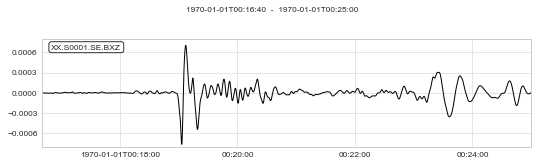

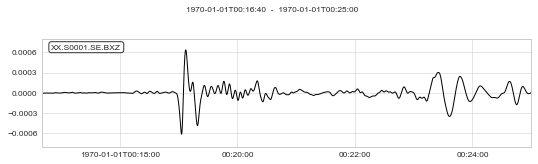

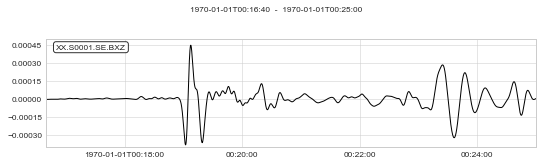

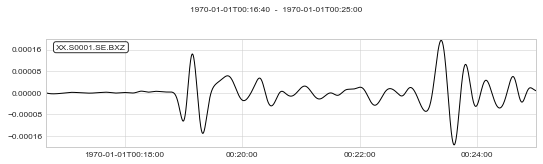

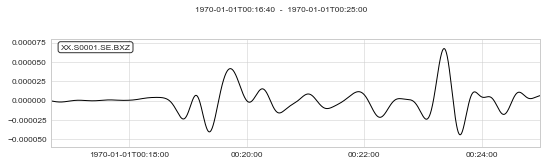

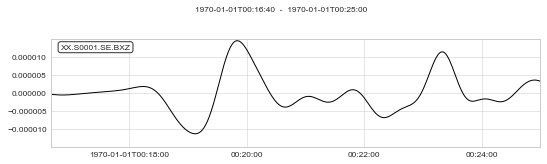

In [5]:
import copy
import collections

seis = collections.OrderedDict()

source_widths = [2.5, 5, 10, 25, 50, 100]

# Request one seismogram for each source with.
for sw in source_widths:
    p = copy.deepcopy(params_ps)
    # The sourcewidth parameter steers the width of the STF.
    p["sourcewidth"] = sw
    # Send it alongside.
    r = requests.get(url=SYNGINE_URL, params=p)
    assert r.ok, str(r.reason)
    # Get the data and parse it as an ObsPy object.
    with io.BytesIO(r.content) as f:
        tr = obspy.read(f)[0]
    seis[sw] = tr
    # Plot only some phases.
    tr.slice(tr.stats.starttime + 1000, tr.stats.starttime + 1500).plot()

/Users/lion/.miniconda3/envs/seismo_live/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


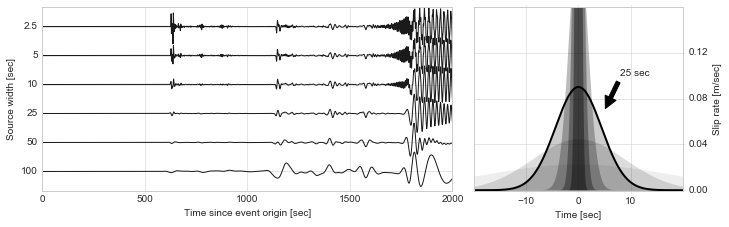

In [6]:
import matplotlib.gridspec as gridspec

# Plotting setup.
fig = plt.figure(figsize=(10, 3))

gs1 = gridspec.GridSpec(1, 1, wspace=0, hspace=0, left=0.05, 
                        right=0.62, bottom=0.14, top=0.99)
ax1 = fig.add_subplot(gs1[0])

gs2 = gridspec.GridSpec(1, 1, wspace=0, hspace=0, left=0.65, 
                        right=0.94, bottom=0.14, top=0.99)
ax2 = fig.add_subplot(gs2[0])

plt.sca(ax1)

# Now plot all the seismograms.
for _i, (sw, tr) in enumerate(seis.items()):
    tr.normalize()
    plt.plot(tr.times(), 2.0 * tr.data - _i * 3, color="0.1")
plt.legend()
plt.xlim(0, 2000)
plt.yticks([0, -3, -6, -9, -12, -15], [str(_i) for _i in source_widths])
plt.ylim(-17, 2)

plt.xlabel("Time since event origin [sec]")
plt.ylabel("Source width [sec]")
plt.sca(ax2)

# Use an internal instaseis function to get the used STF.
from instaseis.server.util import get_gaussian_source_time_function

dt = 0.01

# Plot all the source time functions.
for _i, sw in enumerate(source_widths):
    sr = get_gaussian_source_time_function(sw, dt)[1]
    #sr = np.concatenate([sr2, np.zeros(1000)])
    alpha = 0.4 - _i * 0.4 / len(source_widths)
    plt.fill_between(np.arange(len(sr)) * dt - sw, sr, color="0.0", alpha=alpha, linewidth=0)
    if sw == 25:
        plt.plot(np.arange(len(sr)) * dt - sw, sr, color="0.0", lw=2)
        
ax2.annotate('25 sec', xy=(5, 0.07), xytext=(8, 0.10),
            arrowprops=dict(facecolor='black', shrink=0.05))
        
plt.grid(True)
plt.xlim(-20, 20)
plt.ylim(-0.0005, 0.16)
plt.xticks([-10, 0, 10])
plt.yticks([0, 0.04, 0.08, 0.12])
plt.xlabel("Time [sec]")
plt.ylabel("Slip rate [m/sec]")

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.yaxis.set_tick_params(length=2)
ax2.yaxis.set_tick_params(pad=4)
ax2.xaxis.set_tick_params(length=2)
ax2.xaxis.set_tick_params(pad=4)
ax2.xaxis.set_tick_params(color="#CCCCCC")
ax2.yaxis.set_tick_params(color="#CCCCCC")


plt.savefig("source_width.pdf")